## Logistic Regression

We try to predict defaulters here using `logistic regression`. A logistic regression model is quite suitable here since we only have 2 classes to classify the data into. That is, defaulters and non defaulters.

In [1]:
#imports
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
# Read cleaned data
data = pd.read_csv("data/cleaned_final.csv")

In [3]:
# Sample 100% of data
shuffled = data.sample(frac=1) 
shuffled.reset_index(drop=True, inplace=True)
shuffled

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0,0.000000,0.001893,0.057239,0.064665,0.239486,1.000000,0.566553,0.460192,0.565217,...,0,0,0,0,0,0,0,0,0,0
1,1,0.052632,0.001316,0.049383,0.344429,0.813295,0.037979,0.990272,0.582326,0.695652,...,0,0,0,0,0,0,0,0,0,0
2,0,0.000000,0.000931,0.158249,0.260475,0.016377,1.000000,0.840589,0.398916,0.652174,...,0,0,0,0,0,0,0,0,0,0
3,0,0.000000,0.002085,0.259259,0.311695,0.562168,0.032047,0.616002,0.369459,0.478261,...,0,0,0,0,0,0,0,0,0,0
4,0,0.000000,0.000546,0.015713,0.257000,0.621969,0.043841,0.744771,0.360011,0.652174,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244275,0,0.000000,0.000546,0.158249,0.429796,0.571184,0.043562,0.691553,0.900792,0.695652,...,0,0,0,0,0,0,0,0,0,0
244276,1,0.000000,0.001508,0.046016,0.268617,0.675492,0.039916,0.829969,0.240100,0.434783,...,0,0,0,0,0,0,0,0,0,0
244277,0,0.000000,0.000354,0.046016,0.421848,0.009187,1.000000,0.646158,0.407948,0.391304,...,0,0,0,0,0,0,0,0,0,0
244278,0,0.105263,0.001123,0.079686,0.064665,0.798003,0.038757,0.994082,0.497707,0.478261,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Split the data into training set and 25% test set
x = shuffled.iloc[:, 1:]
y = shuffled['TARGET']
class_labels = ['Non Defaulter', 'Defaulter']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(195424, 156) (48856, 156) (195424,) (48856,)


In [5]:
def load_model(file_name):
    loaded_model = pickle.load(open(file_name, 'rb'))
    return loaded_model

In [6]:
def save_model(model, file_name):
    pickle.dump(model, open(file_name, 'wb'))

In [7]:
# Train logistic regression model with hyperparam tuning
def train_log_reg_model():
    solver_penalties = {
        'liblinear': ['l1', 'l2'],
        'sag': ['l2', None],
        'saga': ['l1', 'l2', 'elasticnet', None],
        'lbfgs': ['l2', None],
        'newton-cg': ['l2', None],
        'newton-cholesky' : ['l2', None]
    }
    max_score = float('-inf')
    optimal_model = None
    for solver, penalties in solver_penalties.items():
        for penalty in penalties:
            n_jobs = None if solver == 'liblinear' else -1
            l1_ratios = [i/10 for i in range(1,10)] if penalty == 'elasticnet' else [None]
            regularization_strengths = [10 ** (i - 3) for i in range(7)] if penalty is not None else [1.0]
            for c in regularization_strengths:
                for l1_ratio in l1_ratios:
                    logistic_regression_model = LogisticRegression(solver=solver, penalty=penalty, C=c,
                                                                   random_state=0, max_iter=4000, 
                                                                   n_jobs=n_jobs, l1_ratio=l1_ratio)
                    logistic_regression_model.fit(x_train, y_train)
                    score = logistic_regression_model.score(x_test, y_test)
                    if score > max_score:
                        max_score = score
                        optimal_model = logistic_regression_model
    return optimal_model
                    

In [8]:
def plot_cm(model):
    disp = ConfusionMatrixDisplay.from_estimator(model, x_test, y_test,
                                                 cmap="Blues", display_labels=class_labels)
    score = model.score(x_test, y_test)
    true_positives = int(disp.text_[1][1].get_text())
    true_negatives = int(disp.text_[0][0].get_text())
    false_positives = int(disp.text_[0][1].get_text())
    false_negatives = int(disp.text_[1][0].get_text())
    total_non_defaulters = true_negatives + false_positives
    total_defaulters = true_positives + false_negatives
    true_positive_rate = (true_positives / total_defaulters) * 100
    false_negative_rate = (false_negatives / total_defaulters) * 100
    true_negative_rate = (true_negatives / total_non_defaulters) * 100
    false_positive_rate = (false_positives / total_non_defaulters) * 100
    disp.ax_.set_title('Confusion matrix of logistic regression model\n'
                       + f'Accuracy score: {score}\n' 
                       + f'True positive rate: {true_positive_rate}\n' 
                       + f'False negative rate: {false_negative_rate}\n' 
                       + f'True negative rate: {true_negative_rate}\n' 
                       + f'False positive rate: {false_positive_rate}')
    plt.show()

In [9]:
cwd = os.getcwd()
file_name = 'log_reg_predictor.sav'
path = os.path.join(cwd, file_name)
trained_model = None
if os.path.exists(path):
    trained_model = load_model(file_name)
else:
    trained_model = train_log_reg_model()
    save_model(trained_model, file_name)

In [10]:
display(trained_model)
score = trained_model.score(x_test, y_test)
print("Accuracy:", score)

LogisticRegression(C=1, max_iter=4000, n_jobs=-1, penalty='l1', random_state=0,
                   solver='saga')

Accuracy: 0.9221589978712952


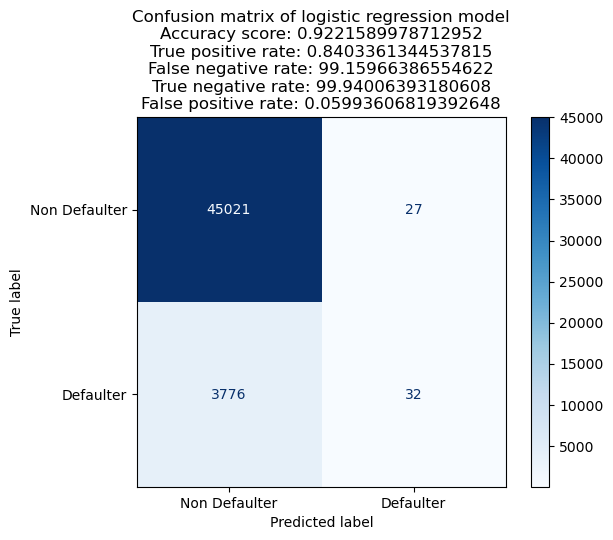

In [11]:
plot_cm(trained_model)